# Defining convolution

In [3]:
import numpy as np
import scipy.signal

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cycler
import matplotlib.path as path
import matplotlib.patches as patches
from matplotlib.transforms import Bbox
import warnings
warnings.simplefilter('ignore')

from matplotlib.animation import FuncAnimation
import matplotlib.style
matplotlib.style.use('bauhaus')

np.random.seed(20200101)

colors = [_['color'] for _ in list(matplotlib.rcParams['axes.prop_cycle'])]

$$
\require{cancel}\notag%
\require{color}\notag%
$$

Now that we've worked through a couple of examples of ways to combine delay, gain, and mixing to produce effects, we can formally define the **convolution** operation.
In full generality, convolution is an operation that takes two sequences $x$ and $h$, and produces a new signal $y$.
Here, $x$ is the input signal and $y$ is the output signal.
The sequence $h[k]$ contains the coefficients by which each delayed signal is scaled before being mixed to produce the output:
- $h[0]$ scales the raw input signal $x[n]$,
- $h[1]$ scales the input delayed by one sample $x[n-1]$,
- $h[2]$ scales $x[n-2]$, and so on.

## The convolution equation

This leads to the **convolution equation**:
\begin{equation}
{\color{#6E3B87}y[n]} = \sum_{k=0}^{K-1} \color{#EC2830}{h[k]} \cdot {\color{#0271AE}x[n-k]}
\end{equation}
This equation is just a slight generalization of the examples we saw in the previous section.
In words, it says that the output signal $y$ is computed by summing together several delayed copies of the input (including delay-0), each multiplied by a coefficient $h[k]$:
\begin{align*}
{\color{#6E3B87}y[n]} = \sum_{k=0}^{K-1} \color{#EC2830}{h[k]} \cdot {\color{#0271AE}x[n-k]} =& \;{\color{#EC2830}h[0]} \cdot {\color{#0271AE}x[n-0]} \;+\\
& \;{\color{#EC2830}h[1]} \cdot {\color{#0271AE}x[n-1]} \;+\\
& \;\quad\quad\cdots \;+\\
& \;{\color{#EC2830}h[K-1]} \cdot {\color{#0271AE}x[n-(K-1)]}
\end{align*}

The animation below illustrates the computaiton of a convolution between a square wave and a sequence $h = [1/2, 1, 0, -1, -1/2]$.
The intermediate steps show how each scaled and shifted copy of $x$ contributes to the total convolution $y$ (bottom subplot).

In [4]:
%%capture
# Animation of convolution

from matplotlib import gridspec

# Make an array of samples with a square wave
fs = 50

# Time sample positions
t = np.linspace(0, 1, num=fs, endpoint=False)
x = scipy.signal.square(2 * np.pi * 3 * t)

# filter coefficients
h = np.array([0.5, 1, 0, -1, -1/2])
K = len(h)

def myconv(x, h):
    y = np.zeros_like(x)
    N, K = len(x), len(h)
    for n in range(N):
        for k in range(K):
            if n < k:
                pass
            else:
                y[n] += h[k] * x[n-k]
    return y

# Arrays to track the partial sums for y
y_partials = []
for k in range(K+1):
    y_partials.append(myconv(x, h[:k]))

    
# Set up the plot skeleton
fig = plt.figure(figsize=(8, 8))

gs = gridspec.GridSpec(2, 3)

ax = plt.subplot(gs[0:1, 0:2])
# This is the input data
p_x_orig = ax.plot(t, x, label=r'$x[n]$', linewidth=1, marker='.',
                       markersize=10, color=colors[3], zorder=2)

# This is the plot that we'll shift around
p_x_copy = ax.plot(t, x, linewidth=1, marker='o',
                       markersize=10, color=colors[0], zorder=1)[0]
p_x_copy.set_visible(False)

# And a label that will change
p_t_label = ax.text(0.5, -2.5, r'$x[n-k]$', color=colors[0], size=20)
p_t_label.set_visible(False)

ax.legend(ncol=2, loc='lower left')
ax.label_outer()


ax2 = plt.subplot(gs[1:2, 0:2], sharex=ax, sharey=ax)

p_x_copy2 = ax2.plot(t, x, linewidth=1, marker='o',
                       markersize=10, color=colors[0], zorder=1)[0]
p_x_copy2.set_visible(False)

y = np.zeros_like(x)
p_y = ax2.plot(t, y_partials[0], label='$y[n]$'.format(k), linewidth=1, marker='o',
                  markersize=10, color=colors[4])[0]
ax2.axvspan(0, (K-1) / fs, alpha=0.1, zorder=-1, color=colors[3])
ax2.set_xlabel('Time [seconds]')
ax2.label_outer()
ax2.legend(loc='lower left')
ax2.set_ylim([-3, 3])
ax2.set_xlim([0, 1]);

ax3 = plt.subplot(gs[0:1, 2])
p_h = ax3.bar(np.arange(K), h, color=colors[1], label='$h[k]$', alpha=0.25,
                linewidth=2, edgecolor=colors[1])
#p_h[3].set_alpha(0.9)
ax3.legend(loc='lower left')
ax3.set_xticks(np.arange(K))
ax3.set_yticks(np.arange(-2, 3))
ax3.set_ylim([-3, 3])
ax3.get_xaxis().set_ticks_position('top')
ax3.get_yaxis().set_ticklabels([]);
fig.tight_layout();

##--
## Animation code
# Animation frame rate
frame_rate = 25
n_frames = 25 * frame_rate

def init():
    return tuple([p_x_copy, p_x_copy2, p_t_label, p_y] + list(p_h))

def conv_animate(time, k, p_x_copy, p_t_label, p_h, p_y):
    # 1s x->x[-k]  (shift)
    # 1s x[-k] -> h[k] * x[-k] (scale)
    # 0.5s pause
    # 1s scaled shift -> accumulate into y
    # 0.5s pause
    
    if k == 0:
        sl = Ellipsis
    else:
        sl = slice(0, -k)
    
    if time == 0:
        for p in [p_x_copy, p_x_copy2]:
            p.set_data(t[sl], x[sl])
            p.set_visible(True)
            p.set_alpha(1)
            p.set_color(colors[0])
        
        
        p_t_label.set_text('$x[n-{}]$'.format(k))
        p_t_label.set_color(colors[0])
        p_t_label.set_visible(True)
        
        for n in range(K):
            if n == k:
                p_h[n].set_alpha(1.0)
            else:
                p_h[n].set_alpha(0.25)
                
    if time == 2:
        p_t_label.set_text('$h[{0}] \\cdot x[n-{0}]$'.format(k))
        p_t_label.set_color(colors[1])
        
        for p in [p_x_copy, p_x_copy2]:
            p.set_color(colors[1])
    if time <= 1:
        alpha = time**0.5
        for p in [p_x_copy, p_x_copy2]:
            p.set_data(t[k:] * alpha + t[sl] * (1 - alpha), x[sl])
        
    elif 1 < time <= 2:
        alpha = (time - 1)**0.5
        for p in [p_x_copy, p_x_copy2]:
            p.set_data(t[k:], (1 - alpha) * x[sl] + alpha * h[k] * x[sl])
        
    elif 2.5 <= time <= 3.5:
        alpha = (time - 2.5)**0.5
        for p in [p_x_copy, p_x_copy2]:
            p.set_data(t[k:], (1-alpha) * h[k] * x[sl])
            p.set_alpha(1-alpha)
        p_y.set_data(t, (1-alpha) * y_partials[k] + alpha * y_partials[k+1])
        
    elif 3.5 < time:
        p_h[k].set_alpha(0.25)
        p_t_label.set_visible(False)
        p_x_copy.set_visible(False)
        p_x_copy2.set_visible(False)

def animate(time):
    # Animation schedule
    #
    # 1s pause
    #--5x
    # 1s x->x[-k]  (shift)
    # 1s x[-k] -> h[k] * x[-k] (scale)
    # 1s scaled shift -> accumulate into y
    # 1s pause
    #--
    # 3s pause
    # 1s y deflate to 0

    # --> 25s total
    if time < 1:
        # Start with a 1s pause
        pass
    elif 21 <= time < 24:
        # pause, do nothing
        pass
    elif 24 <= time:
        # deflate y to loop back
        alpha = (time - 24)**0.5
        p_y.set_data(t, (1-alpha) * y_partials[-1])
    else:
        # infer k from (time - 1) // 4
        k = int((time - 1) // 4)
        conv_animate(time - 1.0 - k * 4, k, p_x_copy, p_t_label, p_h, p_y)

    return tuple([p_x_copy, p_x_copy2, p_t_label, p_y] + list(p_h))

animation = FuncAnimation(fig, animate, init_func=init,
                               frames=np.arange(n_frames, dtype=float)/frame_rate,
                               interval=1000./frame_rate, blit=True);

In [5]:
animation

This operation is so common in signal processing that it gets its own notation:
\begin{equation}
{\color{#6E3B87}y} = {\color{#EC2830}{h}} * {\color{#0271AE}x},
\end{equation}
which is short-hand for the summation above, and we read as *$y$ is $x$ **convolved** with $h$*.

Incidentally, this is why we use $a\cdot b$ to denote scalar (number) multiplication instead of $a*b$.
As we will see in [chapter 9](/ch09), convolution can be viewed abstractly as a kind of "multiplication between signals", and using the same $*$ notation for both operations could lead to confusion.

## Implementing convolution

Convolution can be implemented in a variety of ways.
They all produce the same result, but some implementations may be more or less efficient, or easy to understand.
The first implementation we'll cover is the one used to create the animation above: we compute the contribution due to each delay individually, and accumulate them in the output buffer ``y``:
```python
# Compute the lengths of our input and filter
N = len(x)
K = len(h)

# Allocate an output buffer
y = np.zeros(N)

for k in range(K):
    # Iterate over delay values
    for n in range(N):
        # For each delay value, iterate over all sample indices
        if n >= k:
            # No contribution from samples n < k
            y[n] += h[k] * x[n-k]
```

One thing to observe is that ``y[n]`` is the sum of many pairs of numbers multiplied together.
Because addition does not depend on the order in which arguments appear (e.g., $3 + 4 = 4 + 3$), we can compute this sum in any order we like.
In particular, we can change the order of the loops: the outer loop can range over samples, and the inner loop can range over delay values:
```python
for n in range(N):
    for k in range(K):
        if n >= k:
            y[n] += h[k] * x[n-k]
```
This implementation computes exactly the same `y[n]` as the first one, but it does so **one sample at a time**.
This approach is more common in practice because it allows you to perform convolution in real time, as signals are being generated!
The first example would not allow this, because it has to scan the entire input signal `x` for one delay value before moving on to the next.

There are yet more ways to implement convolution, but we'll have to wait until [chapter 9](/ch09) to see how those work.  Once you're comfortable with the idea of convolution, it's recommended to not implement it yourself, but instead to use a pre-existing implementation like `np.convolve`.

## Special cases

Before going deeper into the theory of convolution, let's step back and see how the idea encompasses familiar operations as special cases.

### Delaying by $d$ samples
In a signal delay, there is no gain, and effectively no *mixing* either.  All we want to do is displace the signal in time by a fixed number $d$ of samples, producing
$$
{\color{#6E3B87}y[n]} = {\color{#0271AE}x[n-d]}.
$$

This is done by setting $h$ to be an array of $d$ zeros followed by a single 1:
$$
{\color{#EC2830}h} = [0, 0, 0, \dots, 1].
$$
This $h$ has $K = d+1$ coefficients.
Plugging this $h$ into the convolution equation, we'd see that all terms are 0 except for the last (corresponding to $h[K-1] = 1$), which results in
\begin{align*}
{\color{#6E3B87}y} = {\color{#EC2830}{h}} * {\color{#0271AE}x}
\quad\Rightarrow\quad {\color{#6E3B87}y[n]} &= {\color{#EC2830}h[K-1]} \cdot {\color{#0271AE}x[n-(K-1)]}\\
&= {\color{#EC2830}h[d+1-1]} \cdot {\color{#0271AE}x[n-(d+1-1)]}\\
&= {\color{#EC2830}h[d]} \cdot {\color{#0271AE}x[n-d]}\\
&= {\color{#0271AE}x[n-d]},
\end{align*}
which is exactly what we want: ${\color{#6E3B87}y[n]} = {\color{#0271AE}x[n-d]}$.

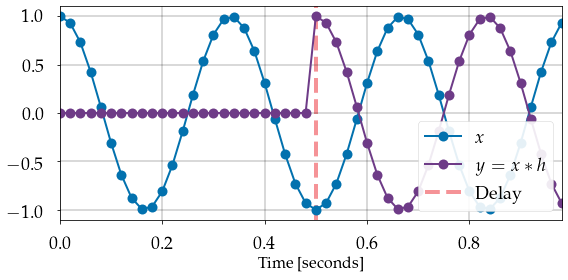

In [6]:
# Example: delaying a signal by convolution
import numpy as np

# These lines are just to make the plots match our styling
import matplotlib
import matplotlib.pyplot as plt
colors = [_['color'] for _ in list(matplotlib.rcParams['axes.prop_cycle'])]

# Let's make a tone at 3Hz and delay it
fs = 50
duration = 1

f0 = 3

times = np.arange(duration * fs) / fs
x = np.cos(2 * np.pi * f0 * times)

# We'll delay by 1/2 a second
# Try changing this number to see how the plot changes
delay = fs // 2
h = np.zeros(delay + 1)
h[delay] = 1

y = np.convolve(x, h)

plt.figure(figsize=(8, 4))
plt.plot(times, x, label=r'$x$', linewidth=2, marker='o', markersize=10)

# For plotting purposes, we'll truncate y to the length of x
plt.plot(times, y[:len(x)], label=r'$y = x * h$', linewidth=2,
           marker='o', markersize=10, color=colors[4])
plt.axvline(delay / fs, alpha=0.5, label='Delay', linestyle='--',
               zorder=-1, color=colors[1])
plt.xlim([times.min(), times.max()])
plt.legend(loc='lower right')
plt.xlabel('Time [seconds]');

### Gain
Applying gain to a signal means that all samples $x[n]$ is scaled by some fixed amount $G$, so
$$
{\color{#6E3B87}y[n]} = {\color{#EC2830}G} \cdot {\color{#0271AE}x[n]}.
$$
This can be implemented by setting $h$ to be an array with only a single element (corresponding to a delay of 0):
$$
{\color{#EC2830}h} = [G].
$$
Again, plugging into the convolution equation, the summation has only one term:
\begin{align*}
{\color{#6E3B87}y} = {\color{#EC2830}{h}} * {\color{#0271AE}x} \quad\Rightarrow\quad {\color{#6E3B87}y[n]} &= {\color{#EC2830}h[0]} \cdot {\color{#0271AE}x[n-0]}\\
&= {\color{#EC2830}G} \cdot {\color{#0271AE}x[n]}.
\end{align*}

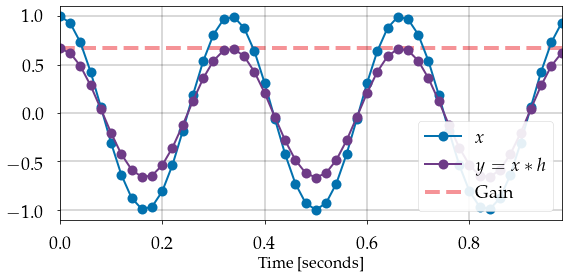

In [7]:
# Example: gaining a signal by convolution
import numpy as np

# These lines are just to make the plots match our styling
import matplotlib
import matplotlib.pyplot as plt
colors = [_['color'] for _ in list(matplotlib.rcParams['axes.prop_cycle'])]

# Let's make a tone at 3Hz and scale it by applying a gain
fs = 50
duration = 1

f0 = 3

times = np.arange(duration * fs) / fs
x = np.cos(2 * np.pi * f0 * times)

# We'll gain by 2/3
# Try changing this number to see how the plot changes.
# What if you make it negative?
gain = 2/3
h = np.array([gain])

y = np.convolve(x, h)

plt.figure(figsize=(8, 4))
plt.plot(times, x, label=r'$x$', linewidth=2, marker='o', markersize=10)
plt.plot(times, y[:len(x)], label=r'$y = x * h$', linewidth=2, marker='o', markersize=10,
           color=colors[4])

plt.axhline(gain, alpha=0.5, label='Gain', linestyle='--', zorder=-1,
               color=colors[1])
plt.legend(loc='lower right')
plt.xlim([times.min(), times.max()])
plt.xlabel('Time [seconds]');

Using convolution to implement gain (or delay) might be overkill, but it's helpful to understand these cases to build an intuition for the properties of convolutional filters.